# Advanced Tutorial 9: Meta Ops

## Overview
In this tutorial, we will discuss:
* [Meta Op Overview](#ta09mo)
* [Sometimes](#ta09so)
* [OneOf](#ta09oo)
* [Repeat](#ta09re)
    * [Static](#ta09res)
    * [Dynamic](#ta09red)
* [Fuse](#ta09fu)
* [Related Apphub Examples](#ta09rae)

## Preliminary Setup

Let's gather some datasets and get some imports out of the way

In [1]:
from fastestimator import Pipeline
from fastestimator.dataset.data import cifar10
from fastestimator.op.numpyop import LambdaOp, NumpyOp
from fastestimator.op.numpyop.multivariate import HorizontalFlip, Rotate, VerticalFlip
from fastestimator.op.numpyop.univariate import Blur, Minmax, ChannelTranspose
from fastestimator.util import to_number, ImgData

train_data, eval_data = cifar10.load_data()

class AddOne(NumpyOp):
    def __init__(self, inputs, outputs, mode = None):
        super().__init__(inputs, outputs, mode)

    def forward(self, data, state):
        return data + 1

<a id='ta09mo'></a>

## Meta Op Overview
We learned about the operator structure in [Beginner Tutorial 3](../beginner/t03_operator.ipynb). Operators are used to build complex computation graphs in FastEstimator. 

Meta Ops are Operators which take other Operators as inputs and modify their functionality. These can allow for much more complicated computation graphs, as we will see in the following examples. They are available as both NumpyOps for use in a `Pipeline`, and as TensorOps for use in a `Network`.

<a id='ta09so'></a>

## Sometimes
`Sometimes` is a meta op which applies a given Op with a specified probability, by default 50% of the time. The `Sometimes` Op cannot be used to create keys which do not already exist in the data dictionary, since then it would not be clear what should be done when the Op decides not to execute. One convenient way to create default values is to first use a `LambdaOp`, as described in [Advanced Tutorial 3](./t03_operator.ipynb). 

In [2]:
from fastestimator.op.numpyop.meta import Sometimes  # Note that there is also a Sometimes in tensorop.meta

pipeline = Pipeline(train_data=train_data,
                    eval_data=eval_data,
                    batch_size=4,
                    ops=[LambdaOp(fn=lambda x: x, inputs="x", outputs="x_out"),
                         Sometimes(HorizontalFlip(image_in="x", image_out="x_out", mode="train"), prob=0.5)
                        ]
                   )

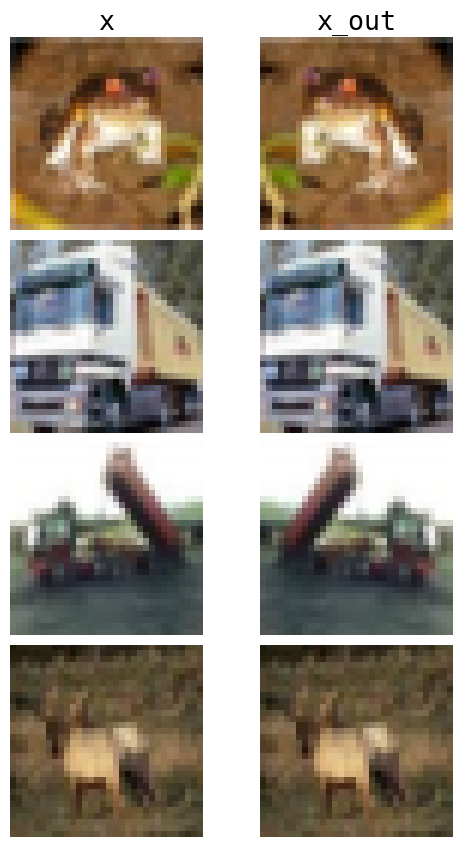

In [3]:
data = pipeline.get_results()
img = ImgData(x=to_number(data["x"]), x_out=to_number(data["x_out"]))
fig = img.paint_figure()

<a id='ta09oo'></a>

## OneOf
`OneOf` takes a list of Ops for input, and randomly chooses one of them every step to be executed. The Ops to be selected between must all share the same inputs, outputs, and modes.

In [4]:
from fastestimator.op.numpyop.meta import OneOf  # Note that there is also a OneOf in tensorop.meta

pipeline = Pipeline(train_data=train_data,
                    eval_data=eval_data,
                    batch_size=4,
                    ops=[LambdaOp(fn=lambda x: x, inputs="x", outputs="x_out"),
                         OneOf(Rotate(image_in="x", image_out="x_out", mode="train", limit=45), 
                               VerticalFlip(image_in="x", image_out="x_out", mode="train"), 
                               Blur(inputs="x", outputs="x_out", mode="train", blur_limit=7))
                        ]
                   )

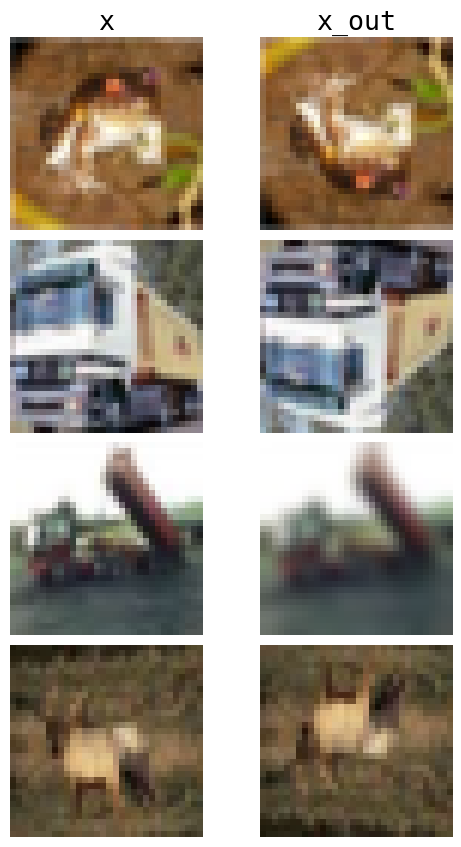

In [5]:
data = pipeline.get_results()
img = ImgData(x=to_number(data["x"]), x_out=to_number(data["x_out"]))
fig = img.paint_figure()

<a id='ta09re'></a>

## Repeat
`Repeat` takes an Op and runs it multiple times in a row. It can be set to repeat for a fixed (static) number of times, or to repeat until a given input function evaluates to False (dynamic). `Repeat` will always evaluate at least once. After performing each forward pass, it will check to see whether the stopping criteria have been met. If using an input function to determine the stopping criteria, any input arguments to that function will be looked up by name from the data dictionary and passed through to the function for evaluation. 

<a id='ta09res'></a>

### Static
We will start with a static example of the `Repeat` Op, which will always run 5 times:

In [6]:
from fastestimator.op.numpyop.meta import Repeat  # Note that there is also a Repeat in tensorop.meta

pipeline = Pipeline(train_data=train_data,
                    eval_data=eval_data,
                    batch_size=4,
                    ops=[LambdaOp(fn=lambda: 0, outputs="z"),
                         Repeat(AddOne(inputs="z", outputs="z"), repeat=5)
                        ]
                   )

In [7]:
data = pipeline.get_results()
print(data['z'])

tensor([5, 5, 5, 5])


<a id='ta09red'></a>

### Dynamic
Now lets see an example of a dynamic repeat op, which uses a lambda function to determine when it should stop. In this case, the repeat will continue so long as z is less than 6.5:

In [8]:
from fastestimator.op.numpyop.meta import Repeat  # Note that there is also a Repeat in tensorop.meta

pipeline = Pipeline(train_data=train_data,
                    eval_data=eval_data,
                    batch_size=4,
                    ops=[LambdaOp(fn=lambda: 0, outputs="z"),
                         Repeat(AddOne(inputs="z", outputs="z"), repeat=lambda z: z < 6.5)
                        ]
                   )

In [9]:
data = pipeline.get_results()
print(data['z'])

tensor([7, 7, 7, 7])


<a id='ta09fu'></a>

## Fuse
`Fuse` takes a list of Ops and combines them together into a single Op. All of the fused Ops must have the same mode. This can be useful in conjunction with the other Meta Ops. For example, suppose you have Op A and Op B, and want to run Sometimes(A) but only want B to execute when A is chosen to run by the Sometimes. You could then run Sometimes(Fuse(A,B)). Or if you wanted to perform mini-batch training within a network, you could do something like Repeat(Fuse(Model, Loss, Update)). Let's try an example where we either leave an image alone, or perform both a horizontal and vertical flip on it:

In [10]:
from fastestimator.op.numpyop.meta import Sometimes, Fuse  # Note that Sometimes and Fuse are also available in tensorop.meta

pipeline = Pipeline(train_data=train_data,
                    eval_data=eval_data,
                    batch_size=4,
                    ops=[LambdaOp(fn=lambda x: x, inputs="x", outputs="x_out"),
                         Sometimes(
                             Fuse([
                                 HorizontalFlip(image_in="x", image_out="x_out", mode="train"),
                                 VerticalFlip(image_in="x_out", image_out="x_out", mode="train")]))
                        ]
                   )

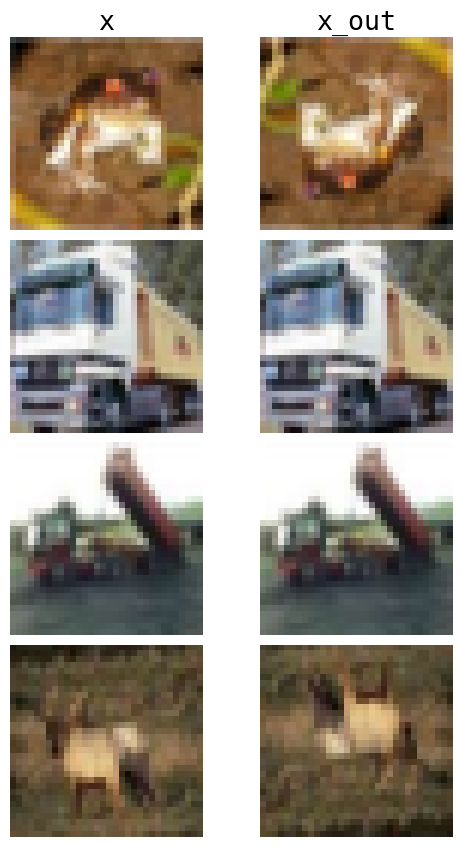

In [11]:
data = pipeline.get_results()
img = ImgData(x=to_number(data["x"]), x_out=to_number(data["x_out"]))
fig = img.paint_figure()

<a id='ta09rae'></a>

## Apphub Examples 

You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [Semantic Segmentation](../../apphub/semantic_segmentation/unet/unet.ipynb)